In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
from WindPy import w
%matplotlib inline

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [4]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [5]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2020-04-30,4233.8174,18.361401
2020-05-29,4258.3735,18.110201
2020-06-30,4616.4142,19.623100
2020-07-31,5219.4998,21.938101
2020-08-31,5322.2441,23.617500


In [6]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [7]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
2020-04-30,587.7222,45935.4585,41989.05824,2580.425,1.5,14.6554,10.7633,20.0851,0.125
2020-05-29,581.3036,43392.5830,44444.76607,2573.885,1.5,14.4473,10.0315,21.2139,0.125
2020-06-30,620.2223,46141.9301,44877.08922,2576.299,1.5,16.3850,12.9688,24.2191,0.125
2020-07-31,703.3781,46237.2699,46802.26671,2605.737,1.5,17.8756,13.0581,25.4805,0.125
2020-08-31,735.7507,46550.5824,49255.16533,2577.195,1.5,18.3779,13.3670,27.2644,0.125


In [8]:
df = df.merge(wind, left_index=True, right_index=True)

In [9]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [10]:
assets_ret = df[asset_columns].pct_change()

In [11]:
fed_rate = df['FDTRMID Index']

In [12]:
assets_ret.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2020-04-30,0.052322,0.043618,0.125167,0.006360
2020-05-29,0.005800,-0.055358,0.058484,-0.002534
2020-06-30,0.084079,0.063360,0.009727,0.000938
2020-07-31,0.130639,0.002066,0.042899,0.011426
2020-08-31,0.019685,0.006776,0.052410,-0.010954


# 计算估值偏离

In [13]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [14]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [15]:
pe_dev = pe_dev.dropna()

In [16]:
pe_dev.tail()

,Wind Index PE,HSI Index PE,SPX Index PE
2020-04-30,-0.035836,-0.066470,0.016699
2020-05-29,-0.042784,-0.127159,0.071448
2020-06-30,0.045011,0.126389,0.217607
2020-07-31,0.172761,0.132314,0.273516
2020-08-31,0.260971,0.155490,0.353108


# 回测

In [17]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [46]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0.01, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0.01, w - 0.25)
    elif dev >= 0.3:
        return max(0.01, w - 0.35)
    else:
        return w

In [47]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [48]:
assets_ret = assets_ret[assets_ret.index >= '2005-01-01']

In [49]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [50]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [51]:
portfolio.tail()

2020-04-30    0.054620
2020-05-29    0.001874
2020-06-30    0.043484
2020-07-31    0.076107
2020-08-31    0.015849
dtype: float64

In [52]:
metric(portfolio)

Annual return: 10.84%
Sharpe ratio: 0.71
Annual volatility: 15.17%
Max drawdown: -50.07%


# 业绩对比

In [53]:
data = w.wsd('000001.SH, CBA00101.CS, HSI.HI,SPX.GI', 'pct_chg', assets_ret.index[0], assets_ret.index[-1], 'Period=M')

In [54]:
bdf = pd.DataFrame(np.array(data.Data).T/100, index=data.Times, columns=data.Codes)

In [55]:
bdf.iloc[0] = 0

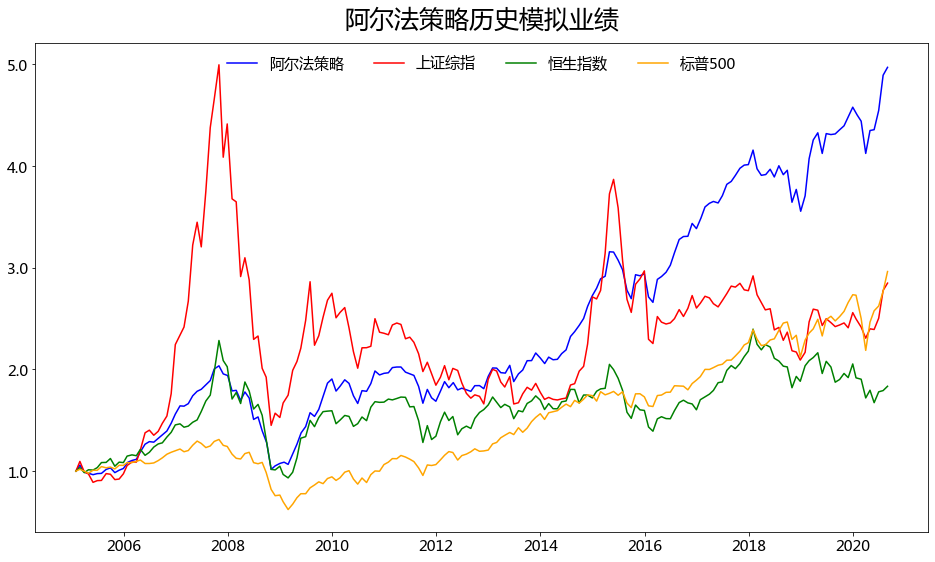

In [56]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'阿尔法策略')
lns2 = ax.plot((1 + bdf['000001.SH']).cumprod(), color='red', label=u'上证综指')
lns3 = ax.plot((1 + bdf['HSI.HI']).cumprod(), color='green', label=u'恒生指数')
lns4 = ax.plot((1 + bdf['SPX.GI']).cumprod(), color='orange', label=u'标普500')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'阿尔法策略历史模拟业绩', fontsize=25, y=1.02)

In [57]:
weight = weight.astype(np.float32)

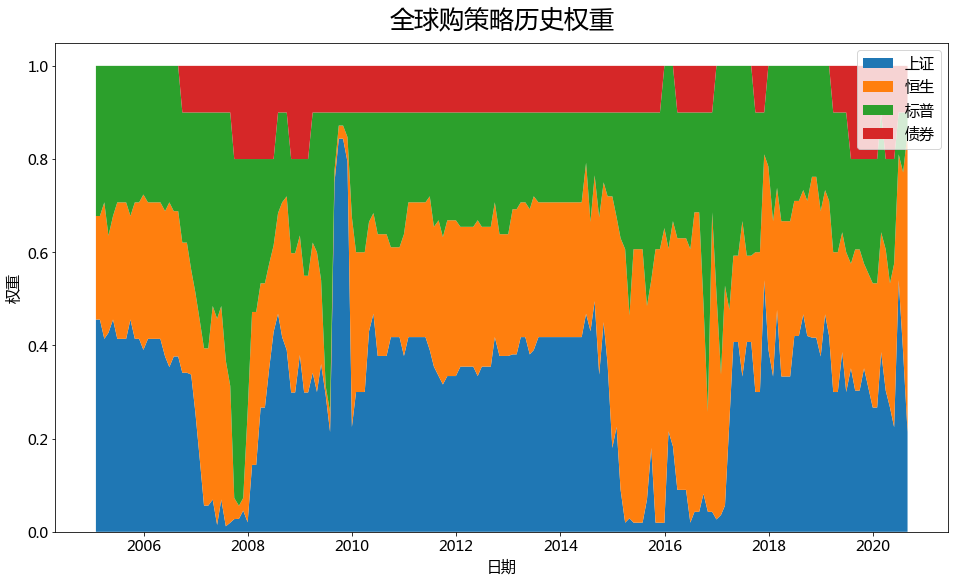

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'债券'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [59]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2020-04-30,0.266667,0.266667,0.266667,0.2
2020-05-29,0.224561,0.350877,0.224561,0.2
2020-06-30,0.540000,0.270000,0.090000,0.1
2020-07-31,0.385714,0.385714,0.128571,0.1
2020-08-31,0.214286,0.642857,0.042857,0.1


In [60]:
weight.to_excel('../data/weight.xlsx')